# AI Prediction of Michigan Water Use

The primary objective of this project is predicting the future impact on Michigan’s water supply based on archived industry and geographical water consumption levels. More specifically, this project will showcase how water consumption changes over time across industries and counties. Population growth data will also be included as an explanatory variable for the increased demand on the industries. With the annual population data, correlations may be identified across the industries to explain changes in demand. Additionally, highlighting the relationships between industries’ water consumption will provide insight into any underlying effects on water use.
	Although water use data is not available for 2023, the predicted results will be ready to compare with the actual water use results when they become publicly available. Data from the past decade is useful in developing prediction models for 2025 and forecasting future trends. Additionally, aggregate data on the total available water is currently inaccessible. This data would be crucial in identifying the threshold at which the water basin would be critically impacted; so future studies will be required to determine preventative measures. Despite the missing water level data, measuring the current impacts is an important step in predicting high-risk industries


# Libraries

In [3]:
import pandas as pd
import dataframe_image as dfi
import datetime
import numpy as np
import seaborn as sns
sns.set_palette('colorblind')
sns.set_style('white')
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
import pickle

import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")
warnings.filterwarnings('ignore', category=UserWarning, module='scipy.stats')
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency AS-JAN will be used.")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Predefined Functions

In [5]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

def save_table(data, file_name):
    data.dfi.export(file_name)

def run_ols(pivot_table, x_feature, y_feature):
    X = pivot_table[x_feature].dropna()
    y = pivot_table[y_feature].dropna()
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model

def acf_testing(ar, title, fig_name, lags = 1, alpha = 1):
    acf_array = acf(ar)
    print(acf_array)
    if alpha < 1:
        conf_int = 1.96/sqrt(len(ar))
        print(f'{(1-alpha)*100}% Confidence Interval: +/- {conf_int}')
    plot_acf(ar, alpha = alpha, lags = lags)
    plt.xlabel('Lags')
    plt.ylabel('Correlation')
    plt.title(title)
    plt.savefig(fig_name)
    plt.show()
    return acf_array

def block_bootstrap(data, block_size, n_bootstraps):
    n = len(data)
    bootstrap_samples = []

    for _ in range(n_bootstraps):
        bootstrap_sample = pd.DataFrame(columns=data.columns)
        
        while len(bootstrap_sample) < n:
            start = np.random.randint(0, n - block_size + 1)
            block = data.iloc[start:start + block_size]
            block = block.dropna(axis = 1, how = 'all')
            bootstrap_sample = pd.concat([bootstrap_sample, block], ignore_index=True)
        
        bootstrap_sample = bootstrap_sample.iloc[:n]
        bootstrap_samples.append(bootstrap_sample)

    return bootstrap_samples

def arima_block_size(data, endog, exog, order, block_size, n_bootstraps):
    bootstrap_samples = block_bootstrap(data, block_size, n_bootstraps)
    BIC_block = {}

    for i, sample in enumerate(bootstrap_samples):
        arima_bs_model = ARIMA(endog, exog = exog, order = order)
        arima_res = arima_bs_model.fit()
        BIC_block[block_size] = arima_res.bic
    return BIC_block

# Data Upload

The Department of Environment, Great Lakes, and Energy's water usage data for the Great Lakes Basin ranges from 2013 to 2022. The dataset includes a list of the various Michigan counties, industries that reside within those counties, and their annual water consumption. The data does not include population growth data which will be supplemented by the U.S. Census Bureau.

* Unnamed: Index number from merging data
* county: Geographical division of Michigan
* gallons_from_great_lakes: Water use from the Great Lakes
* gallons_from_groundwater: Water use from ground water supplies
* gallons_from_inland_surface: Water use from other resevoirs, lakes, rivers, etc.
* total_gallons_all_sources: Aggregated sum of all gallons
* industry: Distinction of entity type that used each water source
* year: Surveyed year

Martusiuk, O. (n.d.). Michigan water use data (2013 to 2022) [Data set]. Kaggle. https://www.kaggle.com/datasets/oleksiimartusiuk/michigan-water-use-data-2013-to-2022/data

U.S. Census Bureau. (n.d.). State population totals: 2010-2020 [Data set]. U.S. Census Bureau. https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/state/totals/

U.S. Census Bureau. (n.d.). State population totals: 2020-2023 [Data set]. U.S. Census Bureau. https://www2.census.gov/programs-surveys/popest/datasets/2020-2023/state/totals/

In [7]:
pop20 = pd.read_csv('data/nst-est2020-alldata.csv')
pop23 = pd.read_csv('data/NST-EST2023-ALLDATA.csv')
df1 = pd.read_csv('data/water_use_data_2013_to_2022.csv')

# Data Wrangling

## Population Data
The population data for both date ranges provided by the U.S. Census Bureau estimates the number of individuals that reside within the states. For this project, Michigan is the only state that will be retained. All other state information will be dropped. Additionally, the dataset contains over 14 extraneous feature categories that are multiplied by the number of years surveyed within each range. To minimize the dimensionality and prepare them for merging, all features that are not annual total population estimates will be dropped. Future studies may be able to make use of analyses with features like natural deaths, imigration rates, or births; but those types of features fall outside the scope of this project. After all extraneous features and observations have been dropped, a single row will remain with a number of features equal to the date ranges. Those rows will be converted to a single column where each year is a single observation.

### pop20

The years range from 2010 - 2020. There are a total of 166 features that the data set includes, however only 8 features are required from this dataset.

In [11]:
pop20.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,...,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019,RNETMIG2020
0,10,0,0,0,United States,308745538,308758105,309327143,311583481,313877662,...,2.561705,2.745929,2.697816,2.980977,3.317393,3.308478,2.926260,2.208328,1.735857,1.450346
1,20,1,0,0,Northeast Region,55317240,55318414,55380764,55608318,55782661,...,0.951355,0.022910,-0.406301,-0.904675,-2.011990,-2.436197,-1.773545,-2.008364,-3.160710,-3.674490
2,20,2,0,0,Midwest Region,66927001,66929737,66975328,67164092,67348275,...,-0.883842,-0.895516,0.062390,-0.697566,-1.320504,-1.176126,-0.487257,-0.800567,-1.205668,-2.011623
3,20,3,0,0,South Region,114555744,114563042,114869421,116019483,117264196,...,5.218129,5.934440,5.373447,6.236211,7.355913,7.220696,6.272594,5.291755,5.479642,5.743507
4,20,4,0,0,West Region,71945553,71946912,72101630,72791588,73482530,...,2.752027,3.083047,3.183793,4.039593,5.004949,5.284859,4.022332,2.968883,1.822074,1.214309


In [12]:
pop20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Columns: 166 entries, SUMLEV to RNETMIG2020
dtypes: float64(60), int64(103), object(3)
memory usage: 74.1+ KB


In [13]:
pop20_1 = pop20[pop20['NAME'] == 'Michigan']

In [14]:
pop20_2 = pop20_1.loc[:, 'POPESTIMATE2013':'POPESTIMATE2020']

In [15]:
pop20_3 = pop20_2.copy()
pop20_3.columns = pop20_3.columns.str.removeprefix('POPESTIMATE')

In [16]:
pop20_4 = pop20_3.transpose().reset_index()

In [17]:
pop20_5 = pop20_4.rename(columns = {'index': 'year', 27: 'population'})

In [18]:
pop20_6 = pop20_5.copy()
pop20_6['year'] = pop20_6['year'].astype('int')
pop20_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        8 non-null      int32
 1   population  8 non-null      int64
dtypes: int32(1), int64(1)
memory usage: 228.0 bytes


### pop23

The years range from 2020 - 2023. There are a total of 60 features that the data set includes, however only 8 features are required from this dataset.

In [20]:
pop23.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,POPESTIMATE2023,...,RNATURALCHG2023,RINTERNATIONALMIG2021,RINTERNATIONALMIG2022,RINTERNATIONALMIG2023,RDOMESTICMIG2021,RDOMESTICMIG2022,RDOMESTICMIG2023,RNETMIG2021,RNETMIG2022,RNETMIG2023
0,10,0,0,0,United States,331464948,331526933,332048977,333271411,334914895,...,1.510043,1.133278,3.003867,3.409196,0.000000,0.000000,0.000000,1.133278,3.003867,3.409196
1,20,1,0,0,Northeast Region,57614141,57430477,57243423,57026847,56983517,...,0.976280,1.403074,3.678035,3.947167,-4.823207,-7.881683,-5.671414,-3.420133,-4.203648,-1.724247
2,30,1,1,0,New England,15119994,15057898,15106108,15120739,15159777,...,-0.019551,1.772643,4.532659,5.024221,1.615767,-3.086263,-2.445863,3.388409,1.446396,2.578358
3,30,1,2,0,Middle Atlantic,42494147,42372579,42137315,41906108,41823740,...,1.336417,1.271165,3.370662,3.557656,-7.121462,-9.606391,-6.837920,-5.850297,-6.235729,-3.280264
4,20,2,0,0,Midwest Region,68987296,68969794,68850246,68783028,68909283,...,0.665803,0.802684,2.098649,2.409866,-2.577042,-2.636615,-1.245226,-1.774357,-0.537966,1.164640


In [21]:
pop23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 60 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SUMLEV                 66 non-null     int64  
 1   REGION                 66 non-null     object 
 2   DIVISION               66 non-null     object 
 3   STATE                  66 non-null     int64  
 4   NAME                   66 non-null     object 
 5   ESTIMATESBASE2020      66 non-null     int64  
 6   POPESTIMATE2020        66 non-null     int64  
 7   POPESTIMATE2021        66 non-null     int64  
 8   POPESTIMATE2022        66 non-null     int64  
 9   POPESTIMATE2023        66 non-null     int64  
 10  NPOPCHG_2020           66 non-null     int64  
 11  NPOPCHG_2021           66 non-null     int64  
 12  NPOPCHG_2022           66 non-null     int64  
 13  NPOPCHG_2023           66 non-null     int64  
 14  BIRTHS2020             66 non-null     int64  
 15  BIRTHS20

In [22]:
pop23_1 = pop23[pop23['NAME'] == 'Michigan']

In [23]:
pop23_2 = pop23_1.loc[:, 'POPESTIMATE2020':'POPESTIMATE2022']

In [24]:
pop23_3 = pop23_2.copy()
pop23_3.columns = pop23_3.columns.str.removeprefix('POPESTIMATE')

In [25]:
pop23_4 = pop23_3.transpose().reset_index()

In [26]:
pop23_5 = pop23_4.rename(columns = {'index': 'year', 36: 'population'})

In [27]:
pop23_6 = pop23_5.copy()
pop23_6['year'] = pop23_6['year'].astype('int')
pop23_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        3 non-null      int32
 1   population  3 non-null      int64
dtypes: int32(1), int64(1)
memory usage: 168.0 bytes


## Concatenating

When concatenating these two tables, the 2023 population date range has a new occurence of the year 2020. This may be due to new methods or information being obtained post-2020 so this occurrence will be treated as the official 2020 population estimate. To join the two tables, pop23 will be concatenated on the end of pop20 as a continuation of the data.

In [29]:
pop20_7 = pop20_6[pop20_5['year'] != '2020']
pop20_7

,year,population
0,2013,9914802
1,2014,9932033
2,2015,9934483
3,2016,9954117
4,2017,9976752
5,2018,9987286
6,2019,9984795


In [30]:
popdf = pd.concat([pop20_7, pop23_6], axis = 0, ignore_index = True)
popdf

,year,population
0,2013,9914802
1,2014,9932033
2,2015,9934483
3,2016,9954117
4,2017,9976752
5,2018,9987286
6,2019,9984795
7,2020,10070627
8,2021,10038117
9,2022,10033281


In [31]:
popdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        10 non-null     int32
 1   population  10 non-null     int64
dtypes: int32(1), int64(1)
memory usage: 252.0 bytes


## Water Use Data

The data provided by he Department of Environment, Great Lakes, and Energy comprehensively details the water use for industries, counties, and from various water sources. For this project, policy and controls for high-risk industries is the primary concern; so counties will be removed from the study as residential uses fall outside the scope of this project. Additionally, the original index from when Martusiuk merged the datasets has no bearing as a feature; so it will be removed.

In [33]:
df1.head()

,Unnamed: 0,county,gallons_from_great_lakes,gallons_from_groundwater,gallons_from_inland_surface,total_gallons_all_sources,industry,year
0,0,Alcona,0,2666085962,4695086047,7361172009,Total All Sectors,2014
1,1,Alger,1512160000,1608226431,799089999,3919476431,Total All Sectors,2014
2,2,Allegan,0,5552539983,3784550040,9337090023,Total All Sectors,2014
3,3,Alpena,40839120000,10948600250,2532270000,54319990250,Total All Sectors,2014
4,4,Antrim,0,12214548686,54526097,12269074783,Total All Sectors,2014


In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6630 entries, 0 to 6629
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Unnamed: 0                   6630 non-null   int64 
 1   county                       6630 non-null   object
 2   gallons_from_great_lakes     6630 non-null   int64 
 3   gallons_from_groundwater     6630 non-null   int64 
 4   gallons_from_inland_surface  6630 non-null   int64 
 5   total_gallons_all_sources    6630 non-null   int64 
 6   industry                     6630 non-null   object
 7   year                         6630 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 414.5+ KB


### Dropping Features

In addition to dropping the unnecessary columns, water source columns will be abbreviated to remove gallon indicators since all of these units are synonymous. Renaming the features will enable cleaner referencing for future manipulation.

In [36]:
df2 = df1.drop(columns = ['Unnamed: 0', 'county']).rename(columns = {
    'gallons_from_great_lakes': 'great_lakes',
    'gallons_from_groundwater': 'groundwater',
    'gallons_from_inland_surface': 'inland',
    'total_gallons_all_sources': 'total'
})

### Rearranging

Year is the main explanatory variable to understand how water use per industry changes over time. Additionally, all other features are divided by industry. After aggregation, population data will be arranged between year and industry features because population is a response variable to the year but not to the industry. Industry being the driving explanatory variable for the water sources will be grouped to the left of the water source features. This rearrangement of features would then put total at the end of the DataFrame because it is the response variable to the different sources.

In [38]:
df2_cols = ['year', 'industry', 'inland', 'great_lakes', 'groundwater', 'total']
df3 = df2[df2_cols]

In [39]:
df3.shape

(6630, 6)

In [40]:
df3['year'].value_counts()

year
2014    664
2018    664
2021    664
2022    664
2016    664
2013    664
2019    664
2017    664
2020    664
2015    654
Name: count, dtype: int64

The industry feature has 8 values in total describing the various industry sectors that Michigan has divided its water use by. The value 'Total All Sectors', is a summation of all other industry values. During EDA and modeling, this value will be analyzed separately to prevent artificially weighing those features.

In [42]:
df3['industry'].value_counts()

industry
Total All Sectors            830
Commercial-Institutional     830
Electric Power Generation    830
Irrigation                   830
Livestock                    830
Other                        830
Public Water Supply          830
Industrial-Manufacturing     820
Name: count, dtype: int64

### Aggregation

Because counties have been removed from analysis, the DataFrame will now need to be aggregated to remove multiple counts of the explanatory features: year and industry. All aggregated features will be sum totalled. Even though this is a reduction in the number of observations, the weights of the individual observations will now be true to the year's estimations.

In [44]:
df4 = df3.groupby(by = ['year', 'industry']).agg('sum').reset_index()
df4.head()

,year,industry,inland,great_lakes,groundwater,total
0,2013,Commercial-Institutional,126374387,1266400,2794492157,2922132944
1,2013,Electric Power Generation,391466708822,2531554552320,1085990916,2924107252058
2,2013,Industrial-Manufacturing,118823433041,111853330944,39327552184,270004316169
3,2013,Irrigation,42803613219,207733128,121431654825,164443001172
4,2013,Livestock,8345185168,0,9882541420,18227726588


In [45]:
df4.shape

(80, 6)

### Water Source

The original data set distinguishes the water sources as different features. To make the data tidy and easier to analyze, the water source features will be aggregated into a single categorical feature and the gallons used will be a continuous feature. The number of gallons used is also difficult to interpret at the single unit scale. To better understand the relationships, gallons will be converted to billions of gallons to better compare with population.

In [47]:
df5 = df4.melt(
    id_vars = ['year', 'industry'],
    value_vars = ['inland', 'great_lakes', 'groundwater', 'total'],
    var_name = 'water_source',
    value_name = 'gallons'
)

In [48]:
df6 = df5.copy()
df6['water_use (Bil. gal)'] = df6['gallons'] / 1000000000

In [49]:
df7 = df6.drop(columns = 'gallons')
df7.head()

,year,industry,water_source,water_use (Bil. gal)
0,2013,Commercial-Institutional,inland,0.126374
1,2013,Electric Power Generation,inland,391.466709
2,2013,Industrial-Manufacturing,inland,118.823433
3,2013,Irrigation,inland,42.803613
4,2013,Livestock,inland,8.345185


In [50]:
df7.shape

(320, 4)

## Joining Population to Water Use

Now that the data has been aggregated and cleaned, the two DataFrames are now ready to be merged. Population will be merged to the water use data as a one-to-many relationship. Population data, like 'year', will be replicated throughout the DataFrame. The repetition of this data will not impact modeling since EDA will account for the relationships between the features.

In [52]:
df8 = df7.merge(popdf, how = 'left', on = 'year')
df8.head()

,year,industry,water_source,water_use (Bil. gal),population
0,2013,Commercial-Institutional,inland,0.126374,9914802
1,2013,Electric Power Generation,inland,391.466709,9914802
2,2013,Industrial-Manufacturing,inland,118.823433,9914802
3,2013,Irrigation,inland,42.803613,9914802
4,2013,Livestock,inland,8.345185,9914802


In [53]:
df9 = df8.copy()
df9['population (Bil.)'] = df9['population'] / 1000000000
df10 = df9.drop(columns = 'population')

### Rearrangement

As mentioned previously, population will be moved between 'year' and 'water_source' because it is assumed to only be a function of time; not industry or water source. Additionally, for organizational purposes, the data will be sorted by year, water source, and industry. Population will also be converted to billions to be scalable with water use.

In [55]:
df11_col = ['year', 'population (Bil.)', 'water_source', 'industry', 'water_use (Bil. gal)']

In [56]:
df11 = df10[df11_col].sort_values(['year', 'water_source', 'industry'])

In [57]:
df11.head(10)

,year,population (Bil.),water_source,industry,water_use (Bil. gal)
80,2013,0.009915,great_lakes,Commercial-Institutional,0.001266
81,2013,0.009915,great_lakes,Electric Power Generation,2531.554552
82,2013,0.009915,great_lakes,Industrial-Manufacturing,111.853331
83,2013,0.009915,great_lakes,Irrigation,0.207733
84,2013,0.009915,great_lakes,Livestock,0.000000
85,2013,0.009915,great_lakes,Other,0.164338
86,2013,0.009915,great_lakes,Public Water Supply,274.498809
87,2013,0.009915,great_lakes,Total All Sectors,2918.280030
160,2013,0.009915,groundwater,Commercial-Institutional,2.794492
161,2013,0.009915,groundwater,Electric Power Generation,1.085991


In [58]:
df11.shape

(320, 5)

### Null Values

These data sets did not come with any null values initially; however, null values will be checked in the event of a corrrupted file.

In [60]:
df11.isna().sum()

year                    0
population (Bil.)       0
water_source            0
industry                0
water_use (Bil. gal)    0
dtype: int64

### Year Data Type

For EDA time series analysis, the years will be adjusted from integer to a datetime object and set as the index. Since there are seven rows eight rows for each year, time indexing for ARIMA time series analysis will be done later. All datetime objects and year indexing will be reverted back to integers as part of the preprocessing.

In [62]:
df11.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320 entries, 80 to 319
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  320 non-null    int64  
 1   population (Bil.)     320 non-null    float64
 2   water_source          320 non-null    object 
 3   industry              320 non-null    object 
 4   water_use (Bil. gal)  320 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 15.0+ KB


In [63]:
df12 = df11.copy()
df12['year'] = pd.to_datetime(df10['year'], format = '%Y')

In [64]:
df12.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320 entries, 80 to 319
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   year                  320 non-null    datetime64[ns]
 1   population (Bil.)     320 non-null    float64       
 2   water_source          320 non-null    object        
 3   industry              320 non-null    object        
 4   water_use (Bil. gal)  320 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 15.0+ KB


## Removing Redundancies

There are two redundant observation values: 'Total All Sectors' and 'total'. These two observations are already accounted for by the other observations and can be calculated during EDA. To prevent an overweighted feature, these two observations will be dropped.

In [66]:
df13 = df12[df12['industry'] != 'Total All Sectors']
df = df13[df13['water_source'] != 'total']
df.shape

(210, 5)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 80 to 78
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   year                  210 non-null    datetime64[ns]
 1   population (Bil.)     210 non-null    float64       
 2   water_source          210 non-null    object        
 3   industry              210 non-null    object        
 4   water_use (Bil. gal)  210 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 9.8+ KB


In [68]:
df.describe()

,year,population (Bil.),water_use (Bil. gal)
count,210,210.000000,210.000000
mean,2017-07-02 07:12:00,0.009983,158.091808
min,2013-01-01 00:00:00,0.009915,0.000000
25%,2015-01-01 00:00:00,0.009934,0.994774
50%,2017-07-02 12:00:00,0.009981,6.507803
75%,2020-01-01 00:00:00,0.010033,86.786002
max,2022-01-01 00:00:00,0.010071,2783.510658
std,NaN,0.000049,490.555693


## Outliers

Even though no outliers are expected with a 

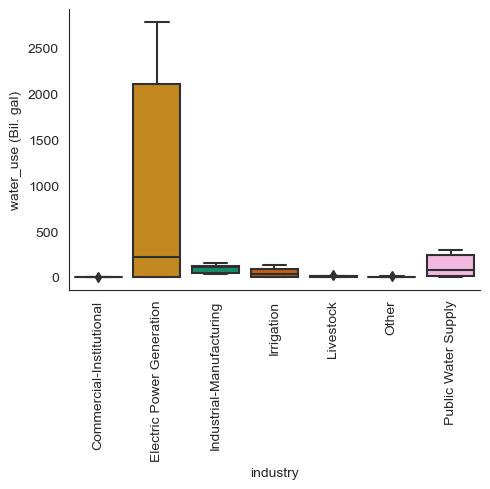

In [70]:
sns.catplot(data = df, y = 'water_use (Bil. gal)', x = 'industry', kind = 'box')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

# Exploratory Data Analysis

The goal of this project is to forecast Michigan's water use; using industries as a potential explanatory feature. To better understand this, water use data for each industry will be plotted over the years to understand how it changes over time. Additionally, correlations between industries must be drawn to see if there are any underlying relationships between changes over time. Lastly, each industry will be analyzed using the autocorrelation function to show any relationships from the data within itself over time.

* How does water use change over time?
* What relationships exist between industry, water source, and population?
* Are there annual changes in water usage?

## How does water use change over time?

To answer this question, industry water use data for each of the water sources (Great Lakes, Groundwater, Inland, and Total) will be plotted over years to show the industry trends. Initial regression will be analyzed to see whether or not linear relationships exist by industry. 

### Water Use

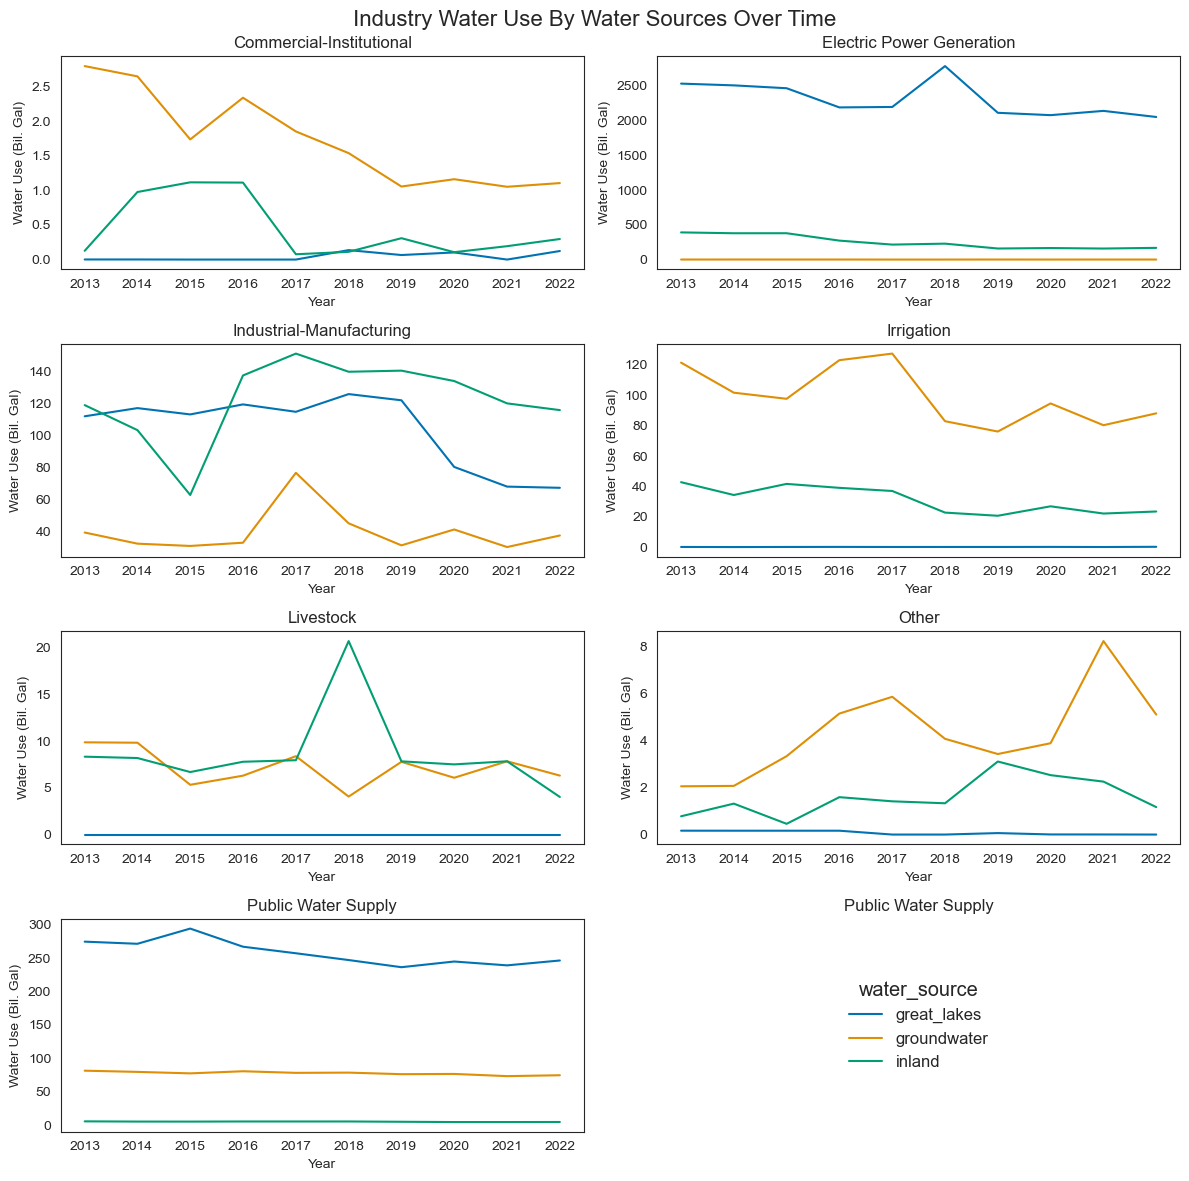

In [74]:
ind_val = df['industry'].unique()

fig, ax = plt.subplots(4, 2, figsize = (12, 12))
ax = ax.flatten()

for i, ind in enumerate(ind_val):
    sns.lineplot(
        data = df[df['industry'] == ind],
        x = 'year',
        y = 'water_use (Bil. gal)',
        hue = 'water_source',
        legend = False,
        ax = ax[i]
    ).set_title(ind)
    ax[i].set_ylabel('Water Use (Bil. Gal)')
    ax[i].set_xlabel('Year')
ax[7].axis('off')

df_zeros = df.set_index('year')
numeric_cols = df_zeros.select_dtypes(include = [np.number]).columns
df_zeros[numeric_cols] = -np.inf
df_zeros = df_zeros.reset_index()

sns.lineplot(
    data = df_zeros,
    x = None,
    y = 'water_use (Bil. gal)',
    hue = 'water_source',
    legend = True,
    ax = ax[-1]
).set_title(ind)
ax[-1].set_ylim([0, 1])
sns.move_legend(ax[-1], 'center', frameon = False, fontsize = 'large', title_fontsize = 'x-large')

fig.suptitle('Industry Water Use By Water Sources Over Time', fontsize = 16)
plt.tight_layout()

plt.savefig('figures/fig_1.png')
plt.show()

Overall only the inland water source for industrial manufacturing and general use; and groundwater for general use increased. The public water supply from all water sources had the least variability; whereas industrial manufacturing had some of the highest variability over the years. Electrical power generation had the largest water consumption out of all the industries, followed by the public water supply. Both industries were the only ones to be mainly sourced by the Great Lakes. The agricultural industries (irrigation and livestock) pulled most of there water from groundwater and inland sources. This may be due to the vast expanse of low urban areas being further from coastal regions near the Great Lakes.

### Population

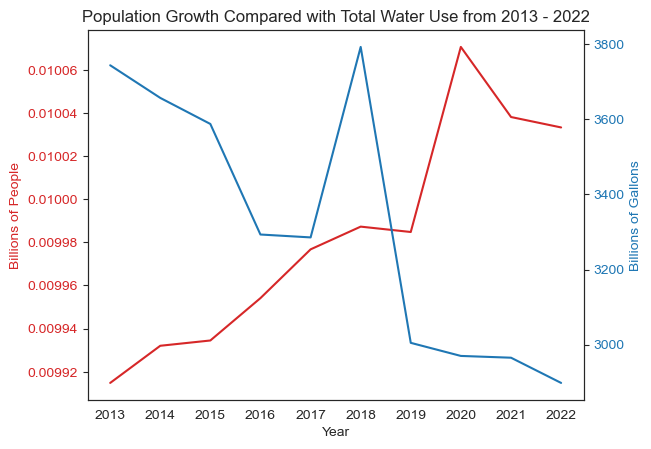

In [77]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(df['year'], df['population (Bil.)'], color = color)
ax1.set_xlabel('Year')
ax1.set_ylabel('Billions of People', color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()

wu = df.groupby('year')['water_use (Bil. gal)'].sum()

color = 'tab:blue'
ax2.plot(wu.index, wu, color = color)
ax2.set_ylabel('Billions of Gallons', color = color)
ax2.tick_params(axis = 'y', labelcolor = color)

plt.title('Population Growth Compared with Total Water Use from 2013 - 2022')
plt.savefig('figures/fig_2.png')
plt.show()

The Michigan population increased 1.2% from 9.9 million to 10.0 million people. Compared to the global growth rate in 2022 (0.83%), this is a major increase in the population. Despite the population increasing, total water use decreased at a similar rate. Although the result contradicts the initial assumption that an increasing population may increase water use demands, a real relationship between population and water use may still exist. To understand the relationship between the two features, linear regression is required.

## What relationships exist between industry, water source, and population?

As shown by the preliminary time plotting, a negative linear relationship may exist between total water use and population. To understand whether population may be related to other factors, correlations will be calculated by water source for each industry.

### How does population relate to general water use?

In [81]:
pop1 = df.groupby('year')['population (Bil.)'].mean().reset_index()
wu2 = wu.reset_index()
wp = pop1.merge(wu2, on = 'year')

In [82]:
wp2 = wp[['population (Bil.)']]
wp3 = sm.add_constant(wp2)

In [83]:
results = sm.OLS(wp['water_use (Bil. gal)'], wp3).fit()
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     water_use (Bil. gal)   R-squared:                       0.619
Model:                              OLS   Adj. R-squared:                  0.571
Method:                   Least Squares   F-statistic:                     13.00
Date:                  Mon, 05 Aug 2024   Prob (F-statistic):            0.00693
Time:                          00:21:01   Log-Likelihood:                -67.486
No. Observations:                    10   AIC:                             139.0
Df Residuals:                         8   BIC:                             139.6
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             

In [84]:
wp_b = results.params['const']
wp_a = results.params['population (Bil.)']
print(f'Intercept: {wp_b}')
print(f'Slope: {wp_a}')

Intercept: 57207.685869625566
Slope: -5398152.759593913


In [85]:
wp_x_theor = np.linspace(wp['population (Bil.)'].min(), wp['population (Bil.)'].max(), 100)
wp_y_theor = (wp_a * wp_x_theor) + wp_b

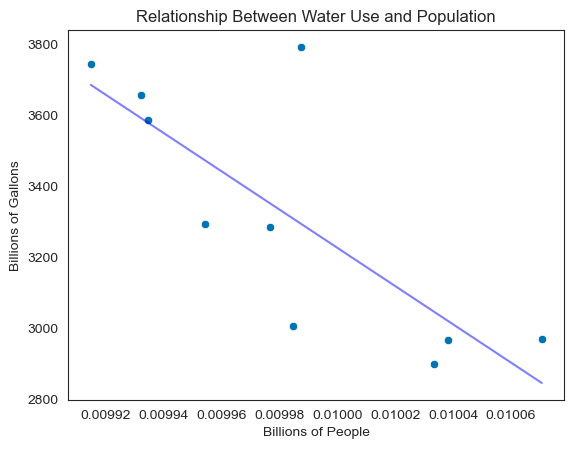

In [86]:
wp_reg = sns.lineplot(x = wp_x_theor, y = wp_y_theor, color = 'blue', alpha = 0.5)
wp_reg = sns.scatterplot(y = wp['water_use (Bil. gal)'], x = wp['population (Bil.)'])
wp_reg = plt.ylabel('Billions of Gallons')
wp_reg = plt.xlabel('Billions of People')
wp_reg = plt.title('Relationship Between Water Use and Population')
plt.savefig('figures/fig_3.png')
plt.show()

As expected, there is a significant (p-value = 0.007) negative linear relationship (adjusted r-squared = 0.571) between the population and total water use. The relationship indicates that for every one new person in Michigan, the total number of gallons used drops by about 0.005 billion. The sample size is low, so more archived data and experimentation would be able to reveal any causal relationship. With the total water use relationship established, the different industries should show a similar trend.

### How does population relate to each industry?

In [89]:
pop2 = pop1[['population (Bil.)']]
pop = sm.add_constant(pop2)
y1 = df.groupby(['year', 'industry'])['water_use (Bil. gal)'].sum().reset_index()

In [90]:
pi_list = []

for ind in ind_val:
    y = y1[y1['industry'] == ind].reset_index()
    results = sm.OLS(y['water_use (Bil. gal)'], pop).fit()
    pi_dict = {
        'industry': ind,
        'slope': results.params['population (Bil.)'],
        'intercept': results.params['const'],
        'R-squared': results.rsquared,
        'Adj. R-squared': results.rsquared_adj,
        'Prob (F-statistic)': results.f_pvalue
    }
    pi_list.append(pi_dict)

In [91]:
pi_df = pd.DataFrame(pi_list).sort_values(by = 'Prob (F-statistic)').reset_index(drop = True)
save_table(pi_df, 'figures/table_1.png')
pi_df

,industry,slope,intercept,R-squared,Adj. R-squared,Prob (F-statistic)
0,Commercial-Institutional,-1.475124e+04,149.468799,0.695470,0.657404,0.002708
1,Public Water Supply,-3.271474e+05,3606.327297,0.673922,0.633162,0.003602
2,Electric Power Generation,-4.598570e+06,48464.624618,0.544615,0.487692,0.014819
3,Other,2.904343e+04,-283.958503,0.470636,0.404466,0.028498
4,Irrigation,-3.191146e+05,3316.240230,0.379757,0.302227,0.057793
5,Livestock,-2.042918e+04,219.821621,0.068883,-0.047506,0.463817
6,Industrial-Manufacturing,-1.471843e+05,1735.161808,0.029759,-0.091521,0.633671


In relation to an increasing population, commercial, public water supplies, and electric power all decrease in water use. General use is the only industry that scaled with population growth. Surprisingly, the agricultural industries did not scale as much with the growing population. This may be due to an increased reliance on those industries creating a weak negative linear relationship. Industrial manufacturing also had a weak relationship with population. Industrial manufacturing may account for demand out of state, and so may not be as heavily influenced by the growing population.

### How does population relate to each water source?

In [94]:
y2 = df.groupby(['year', 'water_source'])['water_use (Bil. gal)'].sum().reset_index()
wat_val = df['water_source'].unique()

In [95]:
pw_list = []

for wat in wat_val:
    y = y2[y2['water_source'] == wat].reset_index()
    results = sm.OLS(y['water_use (Bil. gal)'], pop).fit()
    pw_dict = {
        'water_source': wat,
        'slope': results.params['population (Bil.)'],
        'intercept': results.params['const'],
        'R-squared': results.rsquared,
        'Adj. R-squared': results.rsquared_adj,
        'Prob (F-statistic)': results.f_pvalue
    }
    pw_list.append(pw_dict)

pw_df = pd.DataFrame(pw_list).sort_values(by = 'Prob (F-statistic)').reset_index(drop = True)
save_table(pw_df, 'figures/table_2.png')
pw_df

,water_source,slope,intercept,R-squared,Adj. R-squared,Prob (F-statistic)
0,inland,-1.630446e+06,16697.765387,0.822980,0.800853,0.000290
1,great_lakes,-3.544232e+06,38047.915600,0.449927,0.381168,0.033750
2,groundwater,-2.234743e+05,2462.004882,0.140219,0.032747,0.286388


Groundwater is the least related to population growth which may be represented by the less publicly accessible industries like commercial irrigation. The most impacted water source is inland sources which may be explained by the geographic distribution of the population. Only so many people can aggregate near the Great Lakes so taking advantage of rivers and lakes across the state makes the most sense. What is interesting is that there exists a negative relationship between all water use by source and industry across the years. More experimentation would be required to identify the reason for this downward trend.

### How do the different industries relate internally?

In [98]:
wi_df1 = df.pivot_table(values = 'water_use (Bil. gal)', index = 'industry', columns = 'water_source', aggfunc = 'sum')
wi_df1

water_source,great_lakes,groundwater,inland
industry,,,
Commercial-Institutional,0.430743,17.272733,4.423199
Electric Power Generation,23052.422024,11.880038,2523.795037
Industrial-Manufacturing,1038.728813,397.538748,1222.488999
Irrigation,2.100234,993.139743,311.137998
Livestock,0.000000,71.871307,86.975118
Other,0.723699,43.086659,15.902927
Public Water Supply,2577.159004,776.646383,51.556252


In [99]:
ind_cor = wi_df1.transpose().corr()

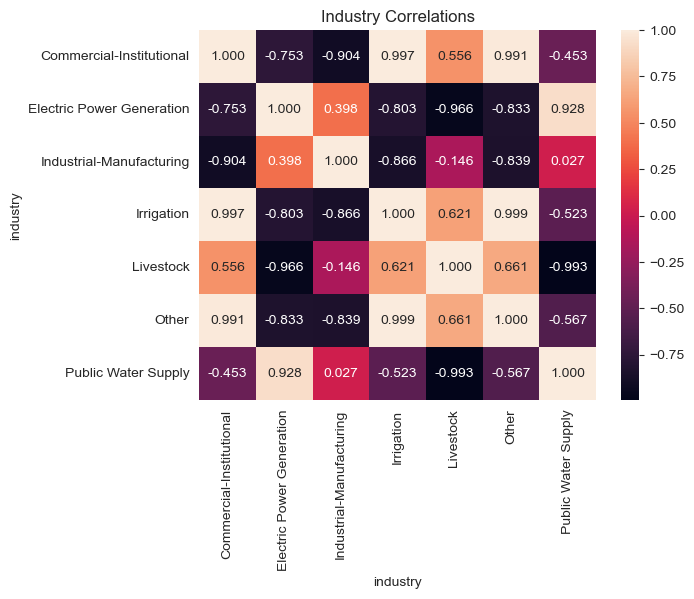

In [100]:
sns.heatmap(ind_cor, annot = True, fmt = '.3f')
plt.title('Industry Correlations')
plt.savefig('figures/fig_4.png')
plt.show()

In [101]:
ind_rel = [
    ('Commercial-Institutional', 'Industrial-Manufacturing'),
    ('Commercial-Institutional', 'Irrigation'),
    ('Electric Power Generation', 'Public Water Supply'),
    ('Electric Power Generation', 'Livestock'),
    ('Industrial-Manufacturing', 'Irrigation'),
    ('Irrigation', 'Other'),
    ('Livestock', 'Public Water Supply')
]

In [102]:
i_list = []

for x_feature, y_feature in ind_rel:
    model = run_ols(wi_df1.transpose(), x_feature, y_feature)
    i_dict = {
        'explanatory': x_feature,
        'response': y_feature,
        'slope': model.params.iloc[1],
        'intercept': model.params.iloc[0],
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'Prob (F-statistic)': model.f_pvalue
    }
    i_list.append(i_dict)
    model = run_ols(wi_df1.transpose(), y_feature, x_feature)
    i_dict = {
        'explanatory': y_feature,
        'response': x_feature,
        'slope': model.params.iloc[1],
        'intercept': model.params.iloc[0],
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'Prob (F-statistic)': model.f_pvalue
    }
    i_list.append(i_dict)

In [103]:
i_df = pd.DataFrame(i_list).sort_values(by = ['Prob (F-statistic)', 'slope']).reset_index(drop = True)
save_table(i_df, 'figures/table_3.png')
i_df

,explanatory,response,slope,intercept,R-squared,Adj. R-squared,Prob (F-statistic)
0,Irrigation,Other,0.042270,1.497580,0.997321,0.994642,0.032967
1,Other,Irrigation,23.594080,-34.167352,0.997321,0.994642,0.032967
2,Irrigation,Commercial-Institutional,0.017299,-0.157333,0.993481,0.986963,0.051456
3,Commercial-Institutional,Irrigation,57.430896,11.874392,0.993481,0.986963,0.051456
4,Public Water Supply,Livestock,-0.035483,93.226436,0.985832,0.971664,0.075957
5,Livestock,Public Water Supply,-27.783115,2606.203398,0.985832,0.971664,0.075957
6,Livestock,Electric Power Generation,-262.650123,22436.376833,0.932534,0.865069,0.167275
7,Electric Power Generation,Livestock,-0.003550,83.232161,0.932534,0.865069,0.167275
8,Electric Power Generation,Public Water Supply,0.095463,320.884655,0.860991,0.721981,0.243232
9,Public Water Supply,Electric Power Generation,9.019134,-1708.439062,0.860991,0.721981,0.243232


The some of the strongest relationships identfied were between irrigation and general (corr = 0.999), livestock and public water supply (corr = -0.993), irrigation and commercial (corr = 0.997),commercial and general (corr = 0.991), electric power and livestock (corr = -0.966), and electric power and public water supply (corr = 0.928).

Despite the strong correlations, only irrigation and general industries had explanatory power (Adj. R-squared = 0.995, p-value = 0.033) towards the other. The general industry has a much more noticeable effect on the change of irrigation water use (slope = 23.594) than the inverse (slope = 0.042). This may just be due to the scale difference between the two features.

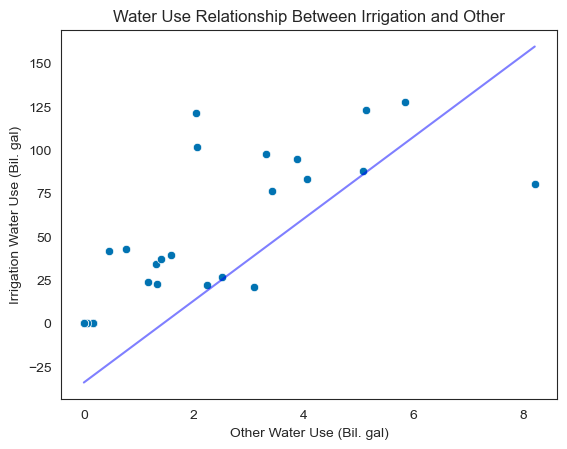

In [105]:
io_x_theor = np.linspace(df[df['industry'] == 'Other']['water_use (Bil. gal)'].min(), df[df['industry'] == 'Other']['water_use (Bil. gal)'].max(), 100)
io_a = i_df[i_df['explanatory'] == 'Other']['slope'].values[0]
io_b = i_df[i_df['explanatory'] == 'Other']['intercept'].values[0]
io_y_theor = (io_a * io_x_theor) + io_b
io_reg = sns.lineplot(x = io_x_theor, y = io_y_theor, color = 'blue', alpha = 0.5)
io_reg = sns.scatterplot(y = df[df['industry'] == 'Irrigation']['water_use (Bil. gal)'].values,
                         x = df[df['industry'] == 'Other']['water_use (Bil. gal)'].values)
io_reg = plt.ylabel('Irrigation Water Use (Bil. gal)')
io_reg = plt.xlabel('Other Water Use (Bil. gal)')
io_reg = plt.title('Water Use Relationship Between Irrigation and Other')
plt.savefig('figures/fig_6.png')
plt.show()

### How do the different water sources relate internally?

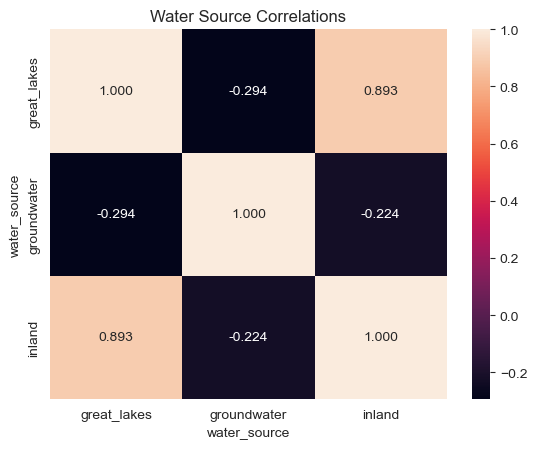

In [107]:
wat_cor = wi_df1.corr()
sns.heatmap(wat_cor, annot = True, fmt = '.3f')
plt.title('Water Source Correlations')
plt.savefig('figures/fig_5.png')
plt.show()

In [108]:
wat_rel = [
    ('great_lakes', 'inland'),
    ('great_lakes', 'groundwater'),
    ('groundwater', 'inland')
]

In [109]:
w_list = []

for x_feature, y_feature in wat_rel:
    model = run_ols(wi_df1, x_feature, y_feature)
    w_dict = {
        'explanatory': x_feature,
        'response': y_feature,
        'slope': model.params.iloc[1],
        'intercept': model.params.iloc[0],
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'Prob (F-statistic)': model.f_pvalue
    }
    w_list.append(w_dict)
    model = run_ols(wi_df1, y_feature, x_feature)
    w_dict = {
        'explanatory': y_feature,
        'response': x_feature,
        'slope': model.params.iloc[1],
        'intercept': model.params.iloc[0],
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'Prob (F-statistic)': model.f_pvalue
    }
    w_list.append(w_dict)

In [110]:
w_df = pd.DataFrame(w_list).sort_values(by = ['Prob (F-statistic)', 'slope']).reset_index(drop = True)
save_table(w_df, 'figures/table_4.png')
w_df

,explanatory,response,slope,intercept,R-squared,Adj. R-squared,Prob (F-statistic)
0,great_lakes,inland,0.099467,223.332762,0.796911,0.756293,0.006832
1,inland,great_lakes,8.011782,-1015.478083,0.796911,0.756293,0.006832
2,groundwater,great_lakes,-6.167461,5846.750636,0.086224,-0.096531,0.522712
3,great_lakes,groundwater,-0.013981,383.474004,0.086224,-0.096531,0.522712
4,groundwater,inland,-0.524534,775.529487,0.050236,-0.139717,0.628984
5,inland,groundwater,-0.095772,387.891108,0.050236,-0.139717,0.628984


The inland water source had the most noticeable relationship (slope = 8.012, Adj. R-squared = 0.756, p-value = 0.007) with the Great Lakes. No other sources had any signifcant nor strong enough (corr > 0.893) to compare with inland and Great Lake water sources. Many of the inland sources may be sourced or connected to the Great Lakes so changes in one may be more noticeable in the other. For industries more reliant on the Great Lakes or inland water sources like electric power generation, industrial manufacturing, and the public water supply; as water use increases from one source, the use also increases with the other. This is important information to plot out future planning for water supplies.

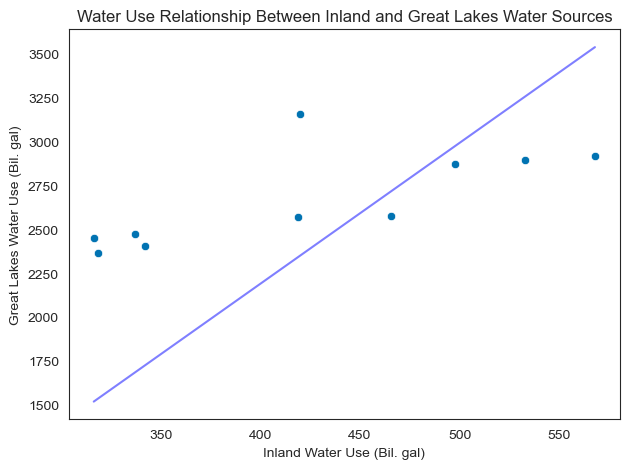

In [112]:
water_df = df.drop(columns = ['industry', 'population (Bil.)']).groupby(['year', 'water_source']).agg('sum').sort_values(by = ['water_source', 'year']).reset_index()

w_x_theor = np.linspace(water_df[water_df['water_source'] == 'inland']['water_use (Bil. gal)'].min(),
                        water_df[water_df['water_source'] == 'inland']['water_use (Bil. gal)'].max(), 100)
w_a = w_df.iloc[1, 2]
w_b = w_df.iloc[1, 3]
w_y_theor = (w_a * w_x_theor) + w_b

w_reg = sns.lineplot(x = w_x_theor, y = w_y_theor, color = 'blue', alpha = 0.5)

w_reg = sns.scatterplot(y = water_df[water_df['water_source'] == 'great_lakes' ]['water_use (Bil. gal)'].values,
                         x = water_df[water_df['water_source'] == 'inland' ]['water_use (Bil. gal)'].values)
w_reg = plt.ylabel('Great Lakes Water Use (Bil. gal)')
w_reg = plt.xlabel('Inland Water Use (Bil. gal)')
w_reg = plt.title('Water Use Relationship Between Inland and Great Lakes Water Sources')
plt.savefig('figures/fig_7.png')
plt.tight_layout()
plt.show()

## Are there annual changes in water usage?

Understanding how the data correlates with itself will enable preliminary predictions of the data. All predictions made in this section assume that 2022 is above the historical average when making time estimations. Forecast modeling will be employed later to compare with the preliminary predictions.

In [114]:
ci = df[df['industry'] == ind_val[0]].groupby('year').agg('sum').drop(columns = ['population (Bil.)', 'water_source', 'industry']).reset_index()
epg = df[df['industry'] == ind_val[1]].groupby('year').agg('sum').drop(columns = ['population (Bil.)', 'water_source', 'industry']).reset_index()
im = df[df['industry'] == ind_val[2]].groupby('year').agg('sum').drop(columns = ['population (Bil.)', 'water_source', 'industry']).reset_index()
ir = df[df['industry'] == ind_val[3]].groupby('year').agg('sum').drop(columns = ['population (Bil.)', 'water_source', 'industry']).reset_index()
li = df[df['industry'] == ind_val[4]].groupby('year').agg('sum').drop(columns = ['population (Bil.)', 'water_source', 'industry']).reset_index()
ot = df[df['industry'] == ind_val[5]].groupby('year').agg('sum').drop(columns = ['population (Bil.)', 'water_source', 'industry']).reset_index()
pws = df[df['industry'] == ind_val[6]].groupby('year').agg('sum').drop(columns = ['population (Bil.)', 'water_source', 'industry']).reset_index()
gl = df[df['water_source'] == wat_val[0]].groupby('year').agg('sum').drop(columns = ['population (Bil.)', 'water_source', 'industry']).reset_index()
gr = df[df['water_source'] == wat_val[1]].groupby('year').agg('sum').drop(columns = ['population (Bil.)', 'water_source', 'industry']).reset_index()
inl = df[df['water_source'] == wat_val[2]].groupby('year').agg('sum').drop(columns = ['population (Bil.)', 'water_source', 'industry']).reset_index()

In [115]:
population = np.array(pop1['population (Bil.)'])
water_use = np.array(wu2['water_use (Bil. gal)'])
commercial = np.array(ci['water_use (Bil. gal)'])
electrical = np.array(epg['water_use (Bil. gal)'])
industrial = np.array(im['water_use (Bil. gal)'])
irrigation = np.array(ir['water_use (Bil. gal)'])
livestock = np.array(li['water_use (Bil. gal)'])
other = np.array(ot['water_use (Bil. gal)'])
public = np.array(pws['water_use (Bil. gal)'])
great_lakes = np.array(gl['water_use (Bil. gal)'])
groundwater = np.array(gr['water_use (Bil. gal)'])
inland = np.array(inl['water_use (Bil. gal)'])

### Population

Because there was a strong correlation between population and water use, tracking seasonal patterns of population growth will be useful in forecasting future impacts on water.

[ 1.          0.64340585  0.41418188  0.07566076 -0.1070113  -0.27556109
 -0.36709258 -0.47239075 -0.26647962 -0.14471315]
95.0% Confidence Interval: +/- 0.6198064213930023


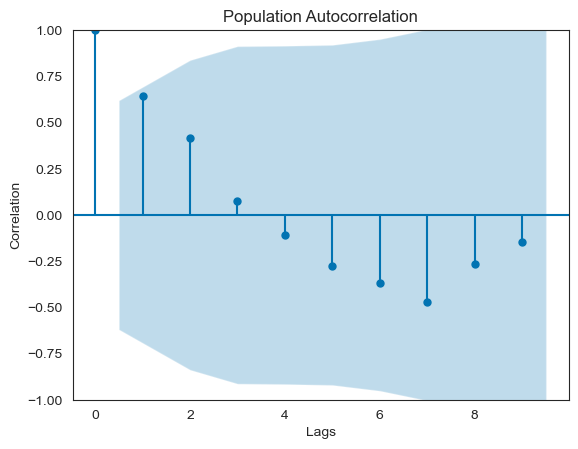

In [117]:
pop_array = acf_testing(population, 'Population Autocorrelation', 'figures/fig_8', alpha = 0.05, lags = 9)

Population has a negative correlation starting with a 4 year cycle which indicates that the state's population should start declining anywhere between 2026 to 2029. Based on how population correlates with total water use, water use should start increasing within the same time frame without confounding factors.

### Total Water Use

[ 1.          0.39937521  0.16797574  0.08005537 -0.10523149  0.02195917
 -0.30045886 -0.3412763  -0.26215625 -0.1602426 ]
95.0% Confidence Interval: +/- 0.6198064213930023


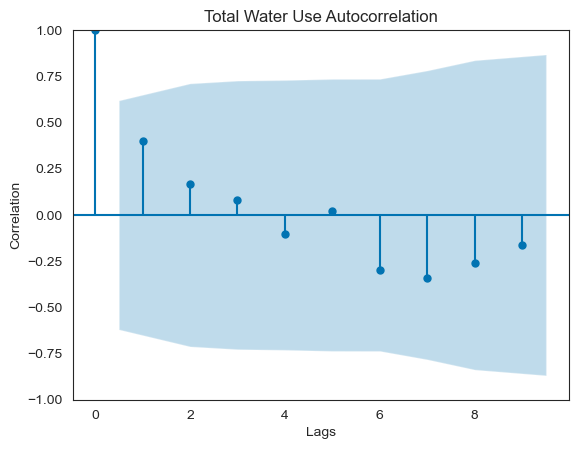

In [120]:
wu_array = acf_testing(water_use, 'Total Water Use Autocorrelation', 'figures/fig_9', alpha = 0.05, lags = 9)

Total water use becomes consistently inversely correlated with itself starting around 6 years which is when population is expected to start decreasing. Water use then is expected to continue decline until about 2027.

### Commercial-Institutional

[ 1.          0.66452304  0.45889428  0.05732826 -0.23929443 -0.39673078
 -0.4325777  -0.3234128  -0.22304489 -0.06568496]
95.0% Confidence Interval: +/- 0.6198064213930023


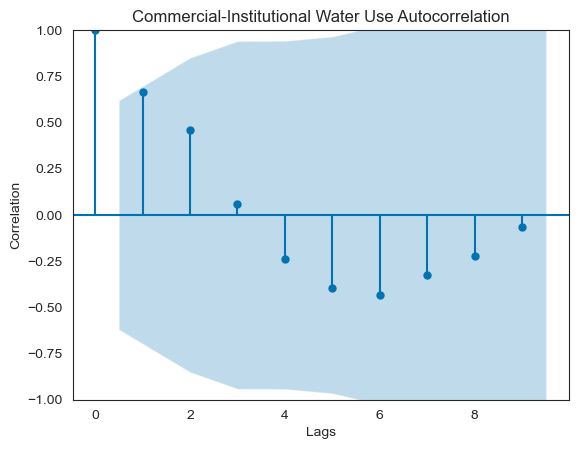

In [123]:
ci_array = acf_testing(commercial, 'Commercial-Institutional Water Use Autocorrelation', 'figures/fig_10', alpha = 0.05, lags = 9)

As expected from earlier EDA, commercial industries closely follow the autocorrelation distribution of populations. An increase in water use for commercial industries is expected to start around 2026.

### Electrical Power Generation

[ 1.          0.28442742  0.07312749  0.10800959 -0.07800767  0.06094602
 -0.27092762 -0.32143672 -0.22260211 -0.1335364 ]
95.0% Confidence Interval: +/- 0.6198064213930023


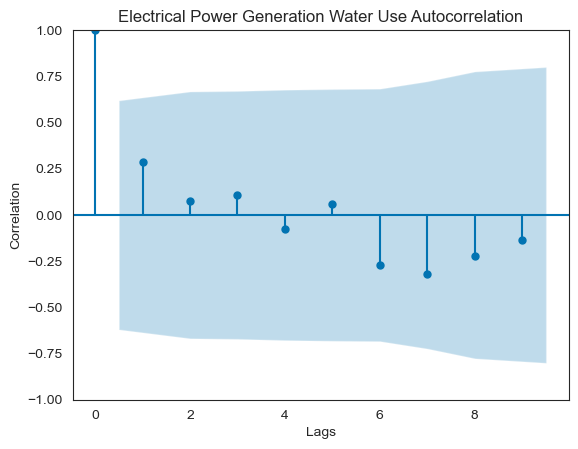

In [126]:
epg_array = acf_testing(electrical, 'Electrical Power Generation Water Use Autocorrelation', 'figures/fig_11', alpha = 0.05, lags = 9)

Electrical industries are less predictable based on historical time series; however starting around 2028, the water use from these industries should start increasing with a declining population.

### Industrial-Manufacturing

[ 1.          0.47157906 -0.18643366 -0.41006625 -0.45303553 -0.24067572
  0.11588102  0.18994823  0.02366372 -0.01086087]
95.0% Confidence Interval: +/- 0.6198064213930023


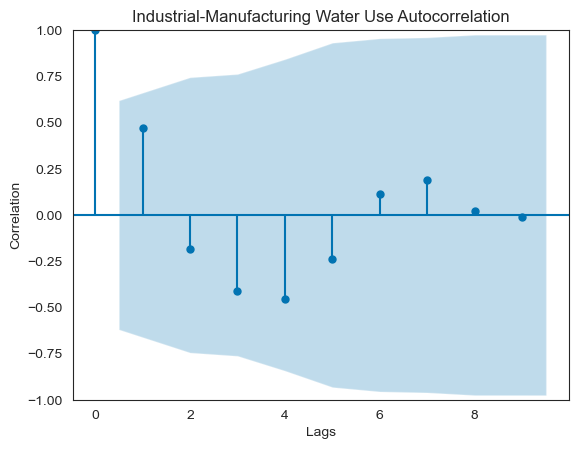

In [129]:
im_array = acf_testing(industrial, 'Industrial-Manufacturing Water Use Autocorrelation', 'figures/fig_12', alpha = 0.05, lags = 9)

By 2024, industrial industries should be increasing their water usage for a total of 4 years based on historical data. The lag correlations are weak, however, and will require further studies to increase the predictive power of the autocorrelation.

### Irrigation

[ 1.          0.41744108  0.02807642  0.15652949 -0.00894491 -0.41246282
 -0.31855041 -0.0975703  -0.16507231 -0.09944624]
95.0% Confidence Interval: +/- 0.6198064213930023


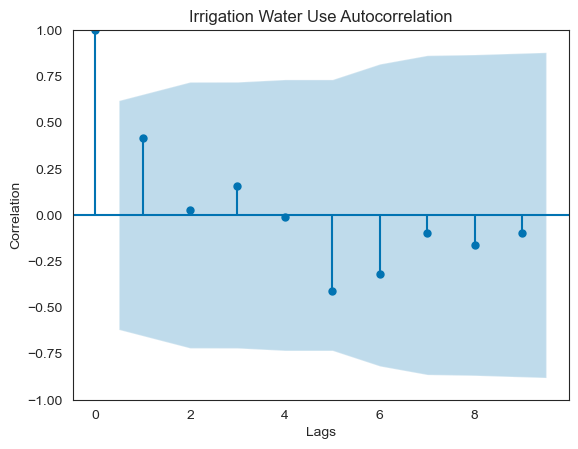

In [132]:
ir_array = acf_testing(irrigation, 'Irrigation Water Use Autocorrelation', 'figures/fig_13', alpha = 0.05, lags = 9)

Irrigation is very difficult to predict based on its own historical data. Because it was highly correlated with other general industries, that data may be used to validate any predictions that can be gained from this autocorrelation.

### Livestock

[ 1.          0.04705969 -0.26639079 -0.26704528 -0.16771315  0.18660117
  0.03513963  0.10856936 -0.08598861 -0.09023201]
95.0% Confidence Interval: +/- 0.6198064213930023


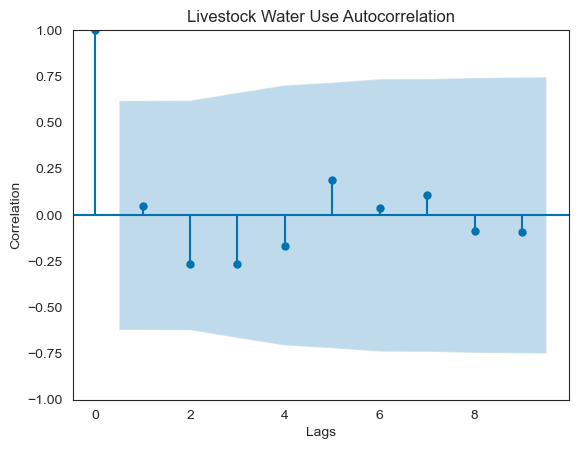

In [135]:
li_array = acf_testing(livestock, 'Livestock Water Use Autocorrelation', 'figures/fig_14', alpha = 0.05, lags = 9)

Livestock industries have extremely low autocorrelation. These industries accounted for very little variation in relation to any other industry. More experimentation would be required to understand the driving forces of livestock water use.

### Public Water Supply

[ 1.          0.69060862  0.46216135  0.05280943 -0.27128116 -0.36816754
 -0.46535336 -0.3232574  -0.19415458 -0.08336536]
95.0% Confidence Interval: +/- 0.6198064213930023


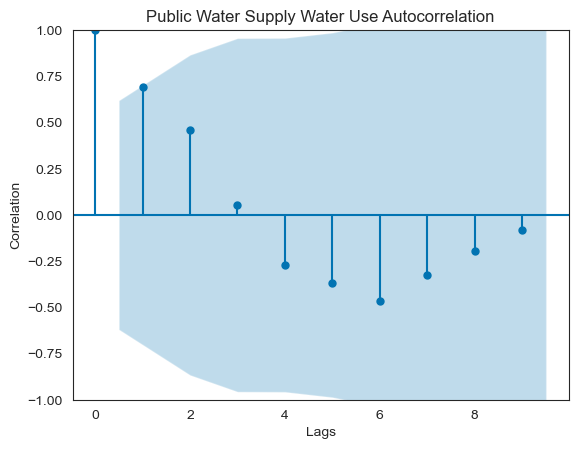

In [138]:
pws_array = acf_testing(public, 'Public Water Supply Water Use Autocorrelation', 'figures/fig_15', alpha = 0.05, lags = 9)

The public water supply follows a very similar autocorrelation distribution to population and commercial industries implying that 2026 should show an increase in water use.

### Other

[ 1.          0.32632531  0.09582333 -0.14096793  0.05512083  0.09046898
 -0.27508278 -0.30042062 -0.33118824 -0.02007888]
95.0% Confidence Interval: +/- 0.6198064213930023


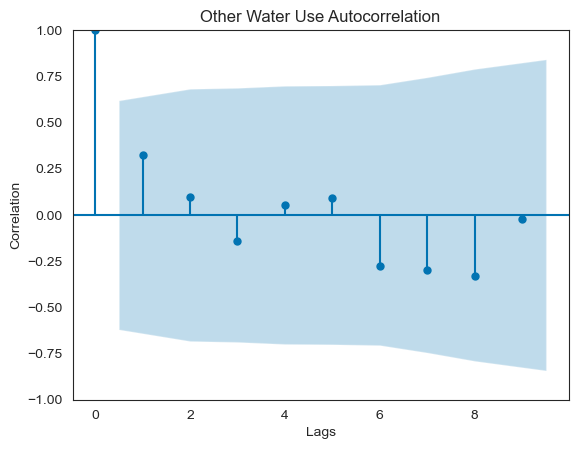

In [141]:
ot_array = acf_testing(other, 'Other Water Use Autocorrelation', 'figures/fig_16', alpha = 0.05, lags = 9)

More studies are needed to understand how the general use industries use water. The fact that it is a bin of miscellaneous uses may be the reason that there is very little correlation with itself.

### Great Lakes

[ 1.          0.19000125 -0.03128702  0.07639329 -0.08390311  0.11159949
 -0.19212631 -0.26923623 -0.18717785 -0.1142635 ]
95.0% Confidence Interval: +/- 0.6198064213930023


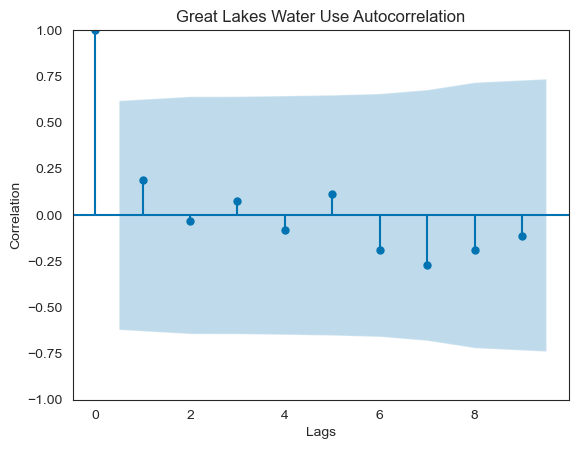

In [144]:
gl_array = acf_testing(great_lakes, 'Great Lakes Water Use Autocorrelation', 'figures/fig_17', alpha = 0.05, lags = 9)

The Great Lakes has a very weak autocorrelation. Because of its relationship to pouplation, an increase in water use may be seen starting 2028, but more data is required to confirm.

### Groundwater

[ 1.          0.18287758 -0.31848189  0.05836633  0.05177088 -0.23811322
 -0.10290541  0.01050269 -0.08919091 -0.05482605]
95.0% Confidence Interval: +/- 0.6198064213930023


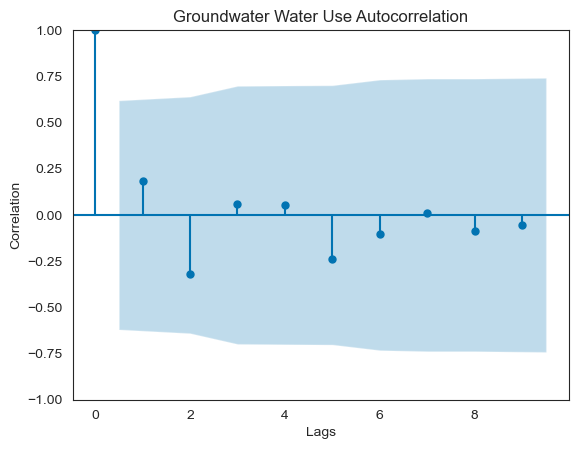

In [147]:
gr_array = acf_testing(groundwater, 'Groundwater Water Use Autocorrelation', 'figures/fig_18', alpha = 0.05, lags = 9)

More studies are needed to understand how groundwater is used. In the timeseries, this water source accounted for very little of the total water use over the past decade. Because of its inaccessiblity or other confounding factors, more data is needed to identify correlated factors.

### Inland

[ 1.          0.7049517   0.43295008  0.14884052 -0.13091106 -0.2617374
 -0.43999532 -0.40662434 -0.35051585 -0.19695832]
95.0% Confidence Interval: +/- 0.6198064213930023


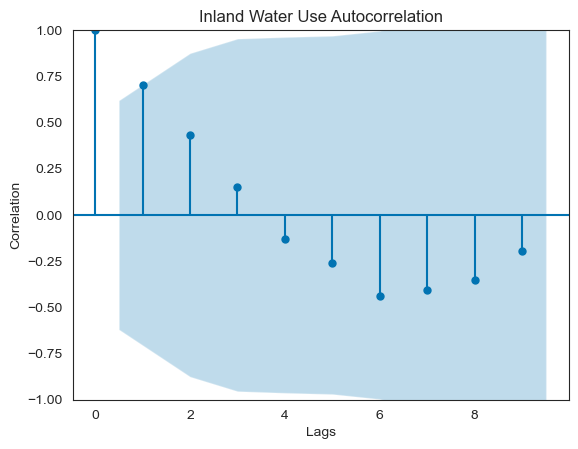

In [150]:
inl_array = acf_testing(inland, 'Inland Water Use Autocorrelation', 'figures/fig_19', alpha = 0.05, lags = 9)

Like commercial and public industries, surface inland water sources correlated with population growth. The historical data indicates that water use may increase starting in 2026 with decreasing populations and increasing total water usage.

## EDA Summary

Water use in Michigan has had a steady decline from 2013 to 2022 which negatively correlates with the state's population growth during that time. If a causal relationship is identified, population growth has the biggest impacts on water used from the Great Lakes and inland sources on the commercial, public, electrical generation, and general industries. This indicates that a encouraging population growth for Michigan may reduce the usage of water in these industries, leaving resources available for new organizations and innovations. The data is limited by not being able to account for the available water in each of these sources and efficiency advancements for industry demands.

Groundwater sources seem to be the most inaccessible water source which may account for it being used, at most, 130 billion gallons in any one year by a single industry. Agricultural and industrial manufacturing industries must have confounding features that drive their water usage. These industries may have a majority of their goods exported to other regions that influence their demand on local resources; or their demand for water is minimal compared to the other resources required to produce their goods and services.

Inter-feature correlations also indicate that irrigation and general use industries are positively correlated with one another. These two industries account for over 99% of the variation for each other. This means that instilling regulations to limit or promote the use of resources in one may result in a change in the other. Similarly, the use of the Great Lakes and surface-level water sources are linked to one another. If the water uses impact one source too much, regulations on the other water sources may mitigate the damages.

Population, total water use, commercial industries, public industries, and inland water sources all displayed strong autocorrelations. The confidence intervals for each acf is large indicating that more data may alleviate some of the uncertainty behind any predictions that could be gained from this EDA. The autocorrelations are consistent with other correlations between industries, water sources, and the population growth identified earlier. Modeling will be required to present a more accurate forecast of the future for each of these featured values.

# Preprocessing

To model, the year must be indexed, and the data aggreagated. The goal of this project is to forecast water use for the state of Michigan. Therefore, population size will not be forecasted, but used as a potential explanatory feature. Impacts of individual industries will be aggregated into a sum total to get a general depiction of the forecasted water use.

In [154]:
data = df.groupby(['year']).agg({'population (Bil.)': 'mean', 'water_use (Bil. gal)': 'sum'})
data

,population (Bil.),water_use (Bil. gal)
year,,
2013-01-01,0.009915,3744.287382
2014-01-01,0.009932,3657.359892
2015-01-01,0.009934,3587.948253
2016-01-01,0.009954,3293.358384
2017-01-01,0.009977,3285.630033
2018-01-01,0.009987,3793.213877
2019-01-01,0.009985,3004.694320
2020-01-01,0.010071,2969.826234
2021-01-01,0.010038,2965.066005


# ARIMA

AutoRegressive Integrated Moving Average (ARIMA) modeling is perfect for our data to predict future water use based on historical moving averages. In order to model the data using ARIMA, the data must be hypertuned to the autoregressive, moving averation, and stationary components.

## Train-Test Split

In [157]:
arima_train, arima_test = data[:8], data[8:]

In [158]:
arima_train

,population (Bil.),water_use (Bil. gal)
year,,
2013-01-01,0.009915,3744.287382
2014-01-01,0.009932,3657.359892
2015-01-01,0.009934,3587.948253
2016-01-01,0.009954,3293.358384
2017-01-01,0.009977,3285.630033
2018-01-01,0.009987,3793.213877
2019-01-01,0.009985,3004.694320
2020-01-01,0.010071,2969.826234


In [159]:
arima_test

,population (Bil.),water_use (Bil. gal)
year,,
2021-01-01,0.010038,2965.066005
2022-01-01,0.010033,2897.895277


## Stationarity

In [161]:
adf_test_wu = adfuller(arima_train['water_use (Bil. gal)'])
print(f'ADF: {adf_test_wu[0]}')
print(f'p-value: {adf_test_wu[1]}')

ADF: -2.403966254123736
p-value: 0.140620090677052


In [162]:
adf_test_pop = adfuller(arima_train['population (Bil.)'])
print(f'ADF: {adf_test_pop[0]}')
print(f'p-value: {adf_test_pop[1]}')

ADF: 0.8617596419792742
p-value: 0.9925704254810674


The high p-value indicates that there is little stationarity. The data will need to be differenced to ensure stationarity prior to modeling to maximize the results.

<AxesSubplot: xlabel='year'>

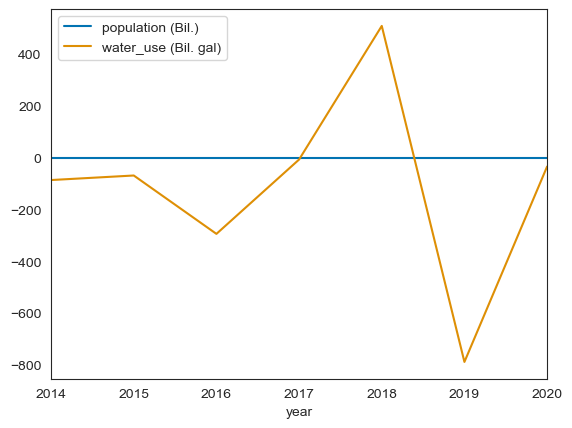

In [164]:
arima_train_diff = arima_train.diff().dropna()
arima_train_diff.plot()

In [165]:
pop_adf = adfuller(arima_train_diff['population (Bil.)'])
print('Population')
print(f'ADF: {pop_adf[0]}')
print(f'p-value: {pop_adf[1]}\n')

wu_adf = adfuller(arima_train_diff['water_use (Bil. gal)'])
print('Water Use')
print(f'ADF: {wu_adf[0]}')
print(f'p-value: {wu_adf[1]}')

Population
ADF: -2.400763346649158
p-value: 0.14152107564122762

Water Use
ADF: -3.451010596756366
p-value: 0.009338074160532653


The predicting value has become stationary so no further differencing is required. The exogeneous feature (population) will stay at 1 order of differencing to match the endogeneous feature.

## P and Q

Based on the ACF produced in EDA, the total water use autocorrelation indicates an order between 1 to 3. The ACF and PACF will be checked again post-differencing to confirm that is still true. Using the Bayesian Information Criterion, the order will be optimized for the lowest BIC to deterine p. Similarly, the partial autocorrelation will be plotted and a range of values will be tested for an optimal BIC.

### p

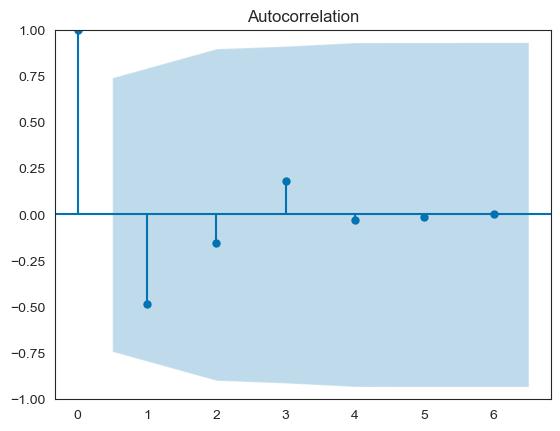

In [169]:
acf_diff_wu = plot_acf(arima_train_diff['water_use (Bil. gal)'])

The ACF shows a drop in correlation after the first lag so p may be optimized at 0.

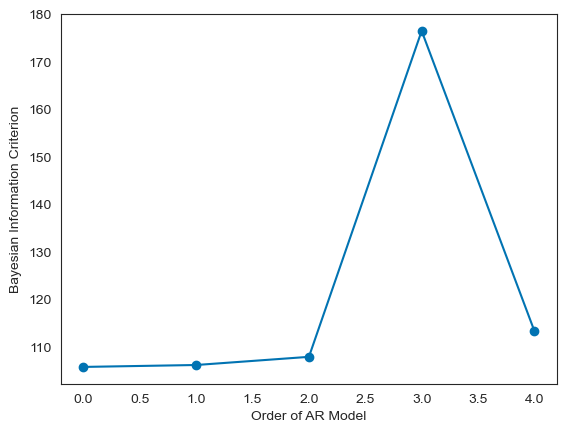

In [171]:
BIC_p = np.zeros(6)
for p in [0, 1, 2, 3, 4, 5]:
    mod = ARIMA(arima_train['water_use (Bil. gal)'], order = (p, 1, 0))
    res = mod.fit()
    BIC_p[p] = res.bic

plt.plot(np.arange(0, 5), BIC_p[1:6], marker = 'o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

In [172]:
BIC_p

array([104.75568522, 105.81887467, 106.2233454 , 107.94118908,
       176.51805225, 113.387789  ])

The Bayesian Informaiton Criterion is consistent with differenced ACF in optimizing p to 0.

### q

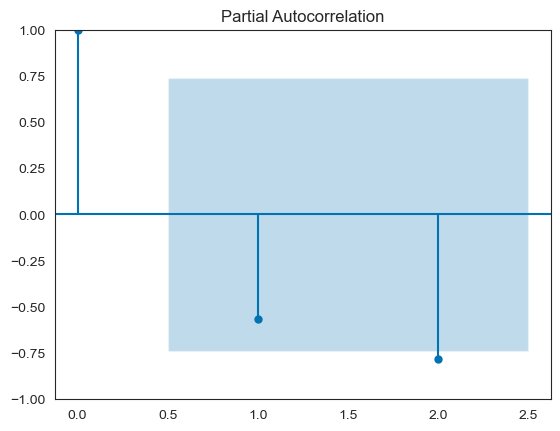

In [175]:
pacf_diff_wu = plot_pacf(arima_train_diff['water_use (Bil. gal)'], lags = 2)

C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All 

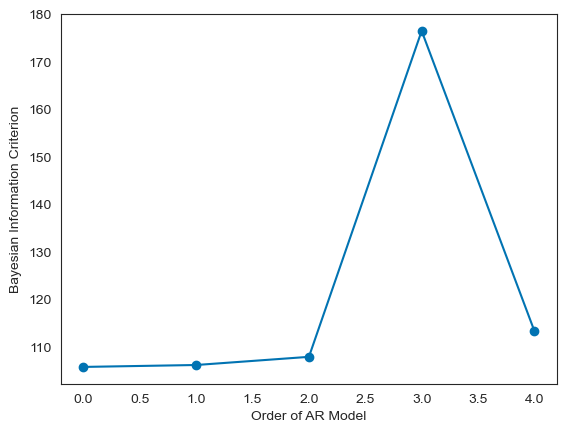

In [176]:
BIC_q = np.zeros(6)
for q in [0, 1, 2, 3, 4, 5]:
    mod = ARIMA(arima_train['water_use (Bil. gal)'], order = (0, 1, q))
    res = mod.fit()
    BIC_q[q] = res.bic

plt.plot(np.arange(0, 5), BIC_p[1:6], marker = 'o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

In [177]:
BIC_q

array([104.75568522, 105.02312684, 106.78764221, 106.83385087,
       108.06854664, 110.20880887])

Similarly to the p value, the PACF and BIC show that an optimal order of 0 would be most appropriate.

## Model

In [180]:
ar_mod = ARIMA(endog = arima_train['water_use (Bil. gal)'], exog = arima_train['population (Bil.)'], order = (0, 1, 0))
ar_res = ar_mod.fit()
ar_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     water_use (Bil. gal)   No. Observations:                    8
Model:                   ARIMA(0, 1, 0)   Log Likelihood                 -51.400
Date:                  Mon, 05 Aug 2024   AIC                            106.801
Time:                          00:21:12   BIC                            106.693
Sample:                      01-01-2013   HQIC                           105.464
                           - 01-01-2020                                         
Covariance Type:                    opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
population (Bil.) -3.809e+05   1.93e+07     -0.020      0.984   -3.83e+07    3.75e+07
sigma2             1.399e+05   7.72e+04      1.812      0.070   -1.15e+04    2.91e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.61   Jarque-Bera (JB):                 0.11
Prob(Q):                              0.11   Prob(JB):                         0.95
Heteroskedasticity (H):              55.91   Skew:                            -0.30
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

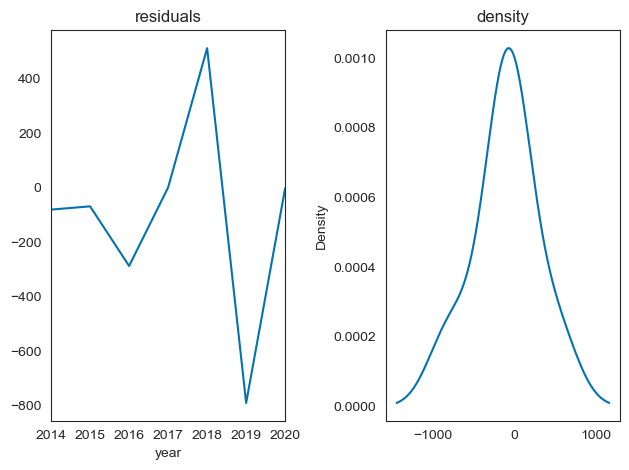

In [181]:
residuals = ar_res.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title = 'residuals', ax = ax[0])
residuals.plot(title = 'density', kind = 'kde', ax = ax[1])
plt.tight_layout()
plt.show()

## ARIMA Forecasting

In [183]:
arima_test['water_use (Bil. gal)']

year
2021-01-01    2965.066005
2022-01-01    2897.895277
Name: water_use (Bil. gal), dtype: float64

In [184]:
arima_test['population (Bil.)']

year
2021-01-01    0.010038
2022-01-01    0.010033
Name: population (Bil.), dtype: float64

In [185]:
arima_test['population (Bil.)'].values.reshape(-1, 1)

array([[0.01003812],
       [0.01003328]])

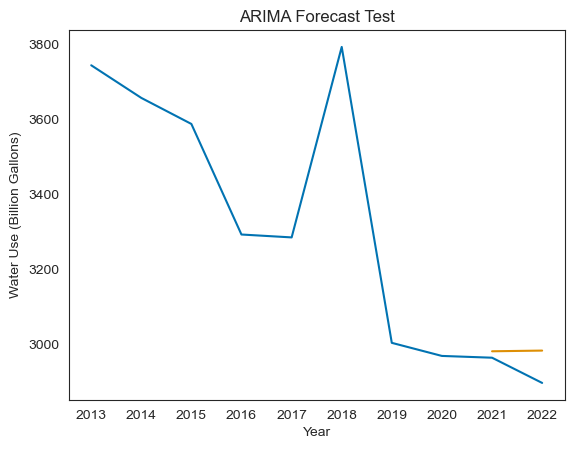

In [186]:
forecast_test = ar_res.forecast(steps = len(arima_test['water_use (Bil. gal)']), exog = arima_test['population (Bil.)'].values.reshape(-1, 1))
arima_data = data.copy()
arima_data['forecast_test'] = [None] * len(arima_train) + list(forecast_test)
plt.plot(arima_data.index, arima_data['water_use (Bil. gal)'])
plt.plot(arima_data.index, arima_data['forecast_test'])
plt.ylabel('Water Use (Billion Gallons)')
plt.xlabel('Year')
plt.title('ARIMA Forecast Test')
plt.show()

## ARIMA Evaluation

In [188]:
arima_mae = mean_absolute_error(arima_test['water_use (Bil. gal)'], forecast_test)
arima_mape = mean_absolute_percentage_error(arima_test['water_use (Bil. gal)'], forecast_test)
arima_rmse = sqrt(mean_squared_error(arima_test['water_use (Bil. gal)'], forecast_test))

print(f'MAE: {arima_mae}')
print(f'MAPE: {arima_mape}')
print(f'RMSE: {arima_rmse}')

MAE: 51.65122237641367
MAPE: 0.017756688453912896
RMSE: 62.11719948721373


In [189]:
np.std(arima_test['water_use (Bil. gal)'])

33.585363957499794

Although only two data points were used, the model had a 2% error from the actual data. The predicitons were off by 62 billion gallons which is within two standard deviations of the mean. More data will alleviate this issue, but this will be the benchmark to compare with the other models.

# Linear Regression

In [192]:
y = data['water_use (Bil. gal)']
x = data.drop(columns = 'water_use (Bil. gal)')

cutoff = int(len(x) * 0.8)
x_train, y_train = x.iloc[:cutoff], y.iloc[:cutoff]
x_test, y_test = x.iloc[cutoff:], y.iloc[cutoff:]

In [193]:
y_pred_base = [y_train.mean()] * len(y_train)
lr_mae_baseline = mean_absolute_error(y_train, y_pred_base)
print(f'Mean Water Use: {y_train.mean()}')
print(f'Baseline MAE: {lr_mae_baseline}')

Mean Water Use: 3417.039796941125
Baseline MAE: 278.66255411962504


In [194]:
lr = LinearRegression()
lr_model = lr.fit(x_train, y_train)

In [195]:
lr_train_predict = lr_model.predict(x_train)
lr_test_predict = lr_model.predict(x_test)
lr_mae_train = mean_absolute_error(y_train, lr_train_predict)
lr_mae_test = mean_absolute_error(y_test, lr_test_predict)

print(f'Train MAE: {lr_mae_train}')
print(f'Test MAE: {lr_mae_test}')

Train MAE: 158.14217615723805
Test MAE: 180.34339650751508


https://medium.com/@sawsanyusuf/linear-regression-with-time-series-data-9186eb1ee607

# Block Bootstrap

With such a small sample size, block bootstrap analysis fo a moving average will be used to ensure data accuracy. The block_size will be optimized to a range of 1 to 4 with 100,000 bootstrap samples to ensure a robust prediction.

n_block = [1, 2, 3, 4]
n_bs_opt = 100
BIC_block = {}

for i, b in enumerate(n_block):
    BIC_block[i] = arima_block_size(d, endog, exog, (2, 0, 1), b, n_bs_opt)

BIC_block

The BIC is the same for all block sizes so the minimum block will be used for the block bootstrap model. This bootstrap settings will be used for the remainder of the bootstrap modeling.

arima_samples = block_bootstrap(d, 1, 10000)

with open('model/arima_bs_samples.pkl', 'wb') as f:
    pickle.dump(arima_samples, f)

#with open('model/arima_bs_samples.pkl', 'rb') as f:
#    arima_bs_samples = pickle.load(f)

n_years = 5

arima_forecasts = []

for s in arima_samples:
    mod = ARIMA(s['water_use'], s[['pop']], order = (2, 0, 1))
    model = mod.fit()
    exog_forecast = exog.iloc[-1].values.reshape(1, -1)
    forecast = model.forecast(steps = n_years, exog = np.tile(exog_forecast, (n_years, 1)))
    arima_forecasts.append(forecast)

